In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution
from Inference.VariationalBoosting import MeanFieldVariationalMixtureDistribution
from Tools.NNtools import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [3]:
# load data and make it in proper shape
data = torch.load('Data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [4]:
model = nn.Sequential( nn.Linear(1, 50),
                       nn.Tanh(), 
                       nn.Linear(50, 1),
                     ).to(device)

In [5]:
param_count = get_param(model).shape[0]

In [6]:
flip_parameters_to_tensors(model)

In [7]:
prior = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

In [8]:
def logprior(x):
    return prior.log_prob(x)

In [9]:
def loglikelihood(theta, model, x, y, sigma_noise):
    def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)
    #set_param(model, theta)
    set_all_parameters(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise],device=device))
    return torch.sum(L).unsqueeze(-1)

In [10]:
def logposterior(theta, model, x, y, sigma_noise):
    return logprior(theta) + loglikelihood(theta, model, x, y, sigma_noise)

In [11]:
def show_variational_posterior_predictive(q):
    x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
    # Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 4) 
    plt.scatter(x_data.cpu(), y_data.cpu())
    for _ in range(1000):
        z = q.sample()
        set_all_parameters(model, z)
        y_test = model(x_test)

        plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [12]:
std = torch.distributions.Gamma(torch.tensor([1.0]), torch.tensor([1.0])).sample()[0].float()
theta = torch.nn.Parameter( torch.empty([1,param_count],device=device).normal_(std=std), requires_grad=True)

In [13]:
optimizer = torch.optim.Adam([theta], lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=0.5, threshold=1e-5, threshold_mode='abs' )

In [ ]:
#def Boost(qC, n_samples_ELBO):
qC.requires_grad_(False)
for c in qC.components:
    c.mu.detach_()
    c.rho.detach_()

In [ ]:
q_new = MeanFieldVariationalDistribution(param_count, sigma=0.0000001, device=device)
std = torch.distributions.Gamma(torch.tensor([1.0]), torch.tensor([1.0])).sample()[0].float()
q_new.mu = nn.Parameter( torch.empty([1,param_count],device=device).normal_(std=std), requires_grad=True)
q_new.rho.requires_grad = False
q_new.mu.requires_grad = True


optimizer = torch.optim.Adam(q_new.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)

liveloss = PlotLosses()
for t in range(100000):
    logs = {}
    optimizer.zero_grad()

    Ln = []
    for j in range(5):
        z = q_new.sample(1)
        LQ = q_new.log_prob(z)
        LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
        Ln.append(LQ - LP)

    L = torch.stack(Ln).mean()
    L.backward()

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step(L.detach().clone().cpu().numpy())
    logs['loss'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)

    if t % 100 == 0:
        liveloss.draw()

    optimizer.step()

    if learning_rate < 0.001:
        break

In [ ]:
unbounded_prop_new = torch.tensor(0.0, device=device).requires_grad_(False)

In [ ]:
q_new.rho.detach_().requires_grad_(True)
q_new.mu.detach_().requires_grad_(True)

optimizer = torch.optim.Adam(list(q_new.parameters())+[unbounded_prop_new], lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.9)

liveloss = PlotLosses()
for t in range(1000000):
    logs = {}
    optimizer.zero_grad()

    Ln = []
    for j in range(n_samples_ELBO):
        Xc = qC.sample(1)
        Xnew = q_new.sample(1)
        prop_new = torch.sigmoid(unbounded_prop_new)

        v = -(1-prop_new)*torch.mean(logposterior(Xc, model, x_data, y_data, sigma_noise=0.1) - qC.log_prob_augmented(Xc, q_new, unbounded_prop_new)) - \
        prop_new*torch.mean(logposterior(Xnew, model, x_data, y_data, sigma_noise=0.1) - qC.log_prob_augmented(Xnew, q_new, unbounded_prop_new))

        Ln.append(v)

    L = torch.stack(Ln).mean()
    L.backward()

    learning_rate = optimizer.param_groups[0]['lr']

    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)

    if t % 100 == 0:
        liveloss.draw()

    optimizer.step()

    if learning_rate < 0.001:
        break

In [ ]:
components = qC.components + [q_new]
proportions = torch.cat([(1-torch.sigmoid(unbounded_prop_new))*qC.proportions, torch.tensor([torch.sigmoid(unbounded_prop_new)],device=device)]).detach()
qC_new = MeanFieldVariationalMixtureDistribution(proportions, components, device=device)

return qC_new

# MAP

In [14]:
q = MeanFieldVariationalDistribution(param_count, sigma=0.0000001, device=device)
std = torch.distributions.Gamma(torch.tensor([1.0]), torch.tensor([1.0])).sample()[0].float()
q.mu = nn.Parameter( torch.empty([1,param_count],device=device).normal_(std=std), requires_grad=True)

q.rho.requires_grad = False
q.mu.requires_grad = True

n_samples_ELBO =10

optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=0.9)

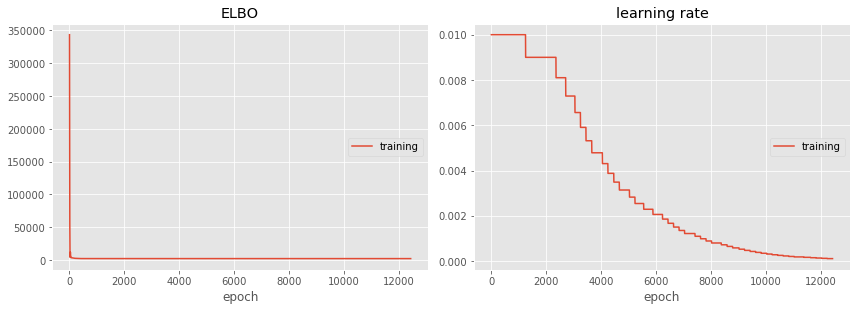

ELBO:
training   (min: 2182.463, max: 430952.094, cur: 2191.830)

learning rate:
training   (min:    0.000, max:    0.010, cur:    0.000)


In [15]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(100000):
    logs = {}
    optimizer.zero_grad()

    Ln = []
    for j in range(n_samples_ELBO):
        z = q.sample(1)
        LQ = q.log_prob(z)
        LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
        Ln.append(LQ - LP)

    L = torch.stack(Ln).mean()
    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.0001:
        break

In [32]:
q.rho.detach_().requires_grad_(True)
q.mu.detach_().requires_grad_(True)

n_samples_ELBO = 10

optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, factor=0.99999)

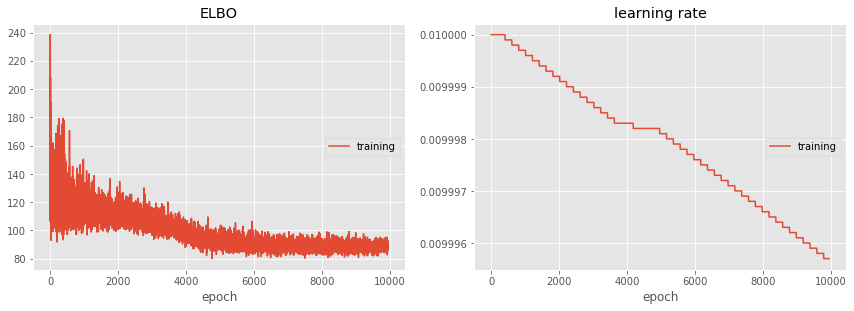

ELBO:
training   (min:   80.057, max:  283.167, cur:   87.629)

learning rate:
training   (min:    0.010, max:    0.010, cur:    0.010)


KeyboardInterrupt: 

In [33]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(100000):
    logs = {}
    optimizer.zero_grad()

    Ln = []
    for j in range(n_samples_ELBO):
        z = q.sample(1)
        LQ = q.log_prob(z)
        LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
        Ln.append(LQ - LP)

    L = torch.stack(Ln).mean()
    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 20 == 0:
        liveloss.draw()
        
    if scheduler.num_bad_epochs >= scheduler.patience:
        n_samples_ELBO += 5

    optimizer.step()
    
    if n_samples_ELBO > 1000:
        break

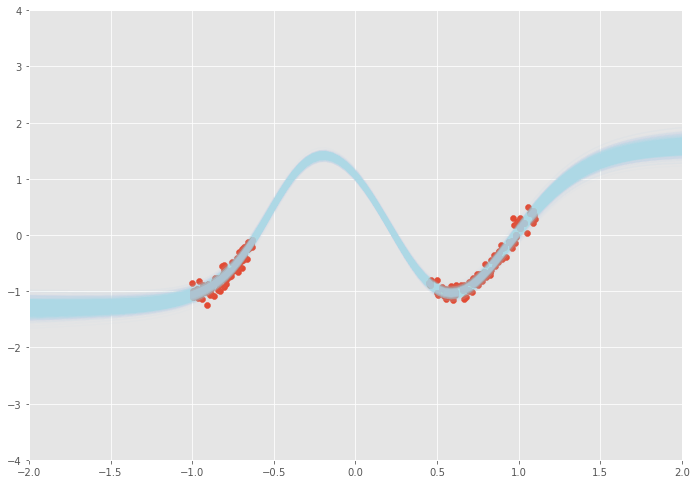

In [34]:
show_variational_posterior_predictive(q)

# Variational Distribution #

In [ ]:
q = MeanFieldVariationalDistribution(param_count, sigma=0.0000001, device=device)
#theta = MAP()
#q.mu = nn.Parameter(theta.squeeze(0).to(device), requires_grad=True) 
std = torch.distributions.Gamma(torch.tensor([1.0]), torch.tensor([1.0])).sample()[0].float()
q.mu = nn.Parameter( torch.empty([1,param_count],device=device).normal_(std=std), requires_grad=True)

q.rho.requires_grad = True
q.mu.requires_grad = True

n_samples_ELBO =10

optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.9)

%matplotlib inline
liveloss = PlotLosses()
for t in range(100000):
    logs = {}
    optimizer.zero_grad()

    Ln = []
    for j in range(n_samples_ELBO):
        z = q.sample(1)
        LQ = q.log_prob(z)
        LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
        Ln.append(LQ - LP)

    L = torch.stack(Ln).mean()
    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = n_samples_ELBO
    liveloss.update(logs)
    
    if scheduler.num_bad_epochs >= scheduler.patience:
        n_samples_ELBO += 10
        scheduler._reset()
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if n_samples_ELBO >= 1000:
        break

In [ ]:
components = [q]
proportions = torch.tensor([1.0], device=device)
qC = MeanFieldVariationalMixtureDistribution(proportions, components, device=device)

In [ ]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = qC.sample()
    set_all_parameters(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [ ]:
qC.proportions

In [ ]:
qC = Boost(qC, 50)

In [ ]:
qC = Boost(qC, 25)

In [ ]:
qC = Boost(qC, 10)

In [ ]:
qC = Boost(qC, 10)

In [ ]:
qC = Boost(qC, 10)

In [ ]:
qC = Boost(qC, 10)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [ ]:
qC.proportions